In [1]:
import inspect
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize
from sklearn.metrics import r2_score

https://stackoverflow.com/questions/78123580/fitting-variable-number-of-lorentzian-peaks-to-a-glob-of-data-in-text-files

In [2]:
def peak(x, x0, s, A):
    return - A * stats.cauchy(loc=x0, scale=s).pdf(x)

In [3]:
def model(x, *p):
    m = len(inspect.signature(peak).parameters) - 1
    n = len(p) // m
    y = np.zeros_like(x)
    for i in range(n):
        y += peak(x, *p[i*m:(i+1)*m])
    return y

In [4]:
x0s = [10, 25, 70, 100, 120, 140]
s0s = [1, 1.5, 2, 1, 0.5, 1]
A0s = [2, 3, 2, 3, 1, 1]
p0 = list(itertools.chain(*zip(x0s, s0s, A0s)))

In [5]:
p0

[10, 1, 2, 25, 1.5, 3, 70, 2, 2, 100, 1, 3, 120, 0.5, 1, 140, 1, 1]

In [6]:
np.random.seed(123456)
xlin = np.linspace(0, 150, 500)
y = model(xlin, *p0)
s = 0.005 * np.ones_like(xlin)
yn = y + s * np.random.normal(size=s.size)

In [7]:
peaks, bases = signal.find_peaks(-yn, prominence=0.2)
peaks, bases

(array([ 33,  83, 233, 333, 399, 466]),
 {'prominences': array([0.63486587, 0.61350699, 0.30987885, 0.94338495, 0.63369006,
         0.30995799]),
  'left_bases': array([  4,  51, 156, 156, 369, 434]),
  'right_bases': array([156, 156, 287, 497, 497, 497])})

In [8]:
def clean_base_indices(lefts, rights):
    _lefts = np.copy(lefts)
    _rights = np.copy(rights)
    for i in range(len(lefts) - 1):
        if lefts[i + 1] < lefts[i]:
            _lefts[i + 1] = rights[i]
        if rights[i + 1] < rights[i]:
            _rights[i] = lefts[i + 1]
        if lefts[i] == lefts[i + 1]:
            _lefts[i + 1] = rights[i]
        if rights[i] == rights[i + 1]:
            _rights[i] = lefts[i + 1]
    return _lefts, _rights

In [9]:
lefts, rights = clean_base_indices(bases["left_bases"], bases["right_bases"])
lefts, rights

(array([  4,  51, 156, 287, 369, 434]), array([ 51, 156, 287, 369, 434, 497]))

In [10]:
lefts, rights = bases["left_bases"], bases["right_bases"]
lefts, rights

(array([  4,  51, 156, 156, 369, 434]), array([156, 156, 287, 497, 497, 497]))

In [11]:
def loss_factory(x, y, s):
    def wrapped(p):
        return np.sum(np.power((y - model(x, *p)) / s, 2)) / (x.size - len(p))
    return wrapped

In [12]:
x0 = list(itertools.chain(*[[xlin[i], 0.1, 0.1] for i in peaks]))
bounds = list(itertools.chain(*[
    [(xlin[lefts[i]], xlin[rights[i]]), (0., np.inf), (0., np.inf)] for i in range(len(peaks))
]))

In [13]:
loss = loss_factory(xlin, yn, s)

In [14]:
sol = optimize.minimize(loss, x0=x0, bounds=bounds)
sol

      fun: 1.0955753119538643
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.73114841e-06, -4.70734565e-05,  6.31272816e-05,  1.57429612e-05,
        3.73034939e-06, -2.41806576e-05,  1.29674131e-05, -5.59552408e-06,
       -2.22932785e-05,  1.63980044e-04, -1.13486998e-04, -5.48450177e-06,
        6.19504837e-05,  6.61692919e-05, -3.19744233e-06,  2.42916605e-05,
       -2.20268249e-05,  1.53876912e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 836
      nit: 41
     njev: 44
   status: 0
  success: True
        x: array([ 10.00233549,   1.01832565,   2.02107376,  24.99880996,
         1.50914703,   3.01233404,  69.98152044,   2.04653551,
         2.01075276,  99.98876123,   1.00539617,   3.00563652,
       119.99496644,   0.50185139,   1.00415731, 140.00815263,
         1.02170953,   1.00824265])

In [15]:
yhat = model(xlin, *sol.x)

In [16]:
score = r2_score(yn, yhat)
score

0.9986663779143068

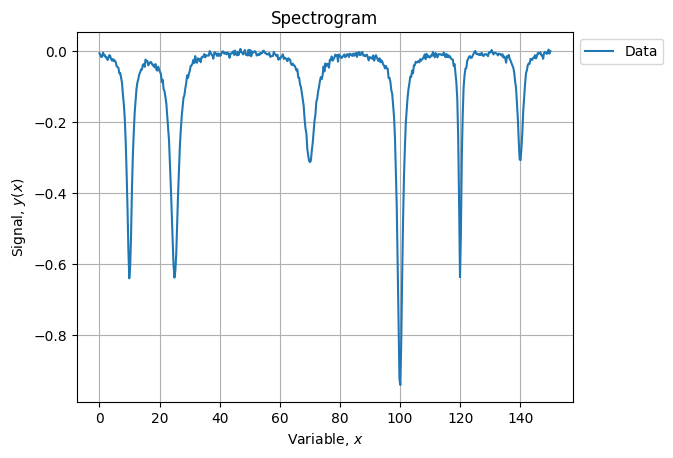

In [17]:
fig, axe = plt.subplots()
axe.plot(xlin, yn, label="Data")
axe.set_title("Spectrogram")
axe.set_xlabel("Variable, $x$")
axe.set_ylabel("Signal, $y(x)$")
axe.legend(bbox_to_anchor=(1, 1))
axe.grid()

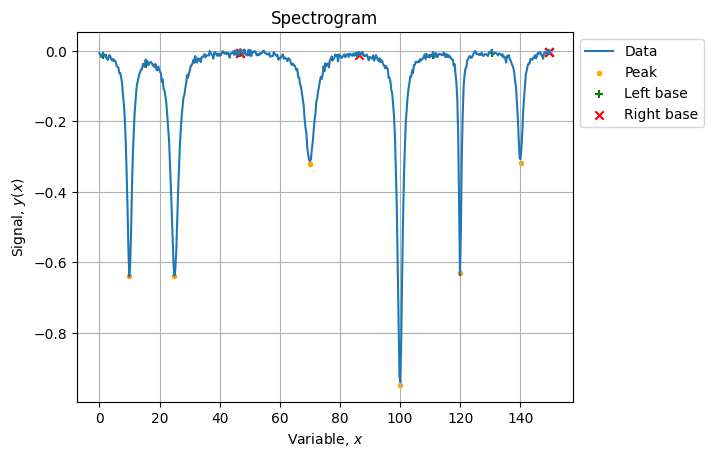

In [18]:
fig, axe = plt.subplots()
axe.plot(xlin, yn, label="Data")
axe.scatter(xlin[peaks], y[peaks], marker=".", color="orange", label="Peak")
axe.scatter(xlin[lefts], y[lefts], marker="+", color="green", label="Left base")
axe.scatter(xlin[rights], y[rights], marker="x", color="red", label="Right base")
axe.set_title("Spectrogram")
axe.set_xlabel("Variable, $x$")
axe.set_ylabel("Signal, $y(x)$")
axe.legend(bbox_to_anchor=(1, 1))
axe.grid()

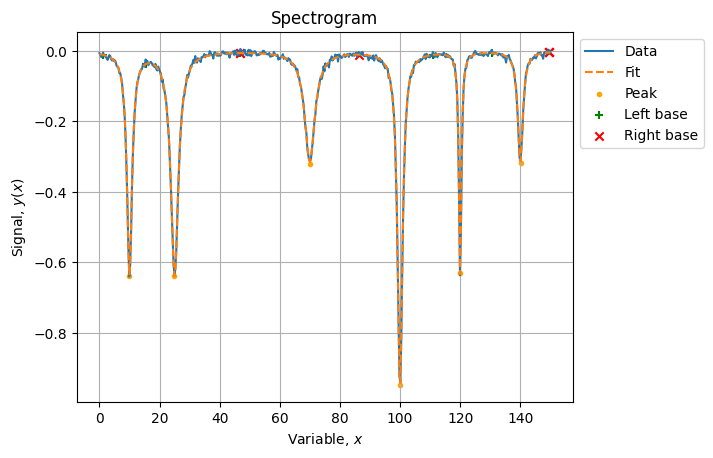

In [19]:
fig, axe = plt.subplots()
axe.plot(xlin, yn, label="Data")
axe.plot(xlin, yhat, "--", label="Fit")
axe.scatter(xlin[peaks], y[peaks], marker=".", color="orange", label="Peak")
axe.scatter(xlin[lefts], y[lefts], marker="+", color="green", label="Left base")
axe.scatter(xlin[rights], y[rights], marker="x", color="red", label="Right base")
axe.set_title("Spectrogram")
axe.set_xlabel("Variable, $x$")
axe.set_ylabel("Signal, $y(x)$")
axe.legend(bbox_to_anchor=(1, 1))
axe.grid()